In [ ]:
# this class represents the board of backgammon
# Original code derived and modified from github repository https://github.com/dunstall/td-gammon, by creator Andrew Dunstall



import numpy as np

# set up two players in backgammon
Player_Red = 0
Player_White = 1


class Board:
    Number_Points = 24   # number of points on backgammon board, 6 points on each quadrant of board
    State_Size = 198    # input size needed for neural network
    Number_Checkers = 15   # each player has 15 checkers on board

    Min_Move = 1     # can move with minimum of 1 from a die
    Max_Move = 6     # can move up to a maximum of 6 from a die

    def __init__(self):          # set up the board with initial positions on each side, initial set up can be found here, https://entertainment.howstuffworks.com/leisure/brain-games/backgammon2.htm
        self.Red_Points = np.array([
            2,0,0,0,0,0,0,0,0,0,0,5,
            0,0,0,0,3,0,5,0,0,0,0,0
        ])
        self.White_Points = np.array([
            2,0,0,0,0,0,0,0,0,0,0,5,
            0,0,0,0,3,0,5,0,0,0,0,0
        ])
        self.Red_Bar = 0  # bar for pieces that were hit by opponent
        self.White_Bar = 0
        self.Red_Removed = 0   # checkers hit by opponent
        self.White_Removed = 0

    def Red_Bar(self):
        return self.Red_Bar

    def White_Bar(self):
        return self.White_Bar

    def won(self, player):   # winner decided when all checkers have been moved off board
        if player == Player_Red:
            return self.Red_Removed == self.Number_Checkers
        if player == Player_White:
            return self.White_Removed == self.Number_Checkers
        return False

    def Red_Points(self):
        return self.Red_Points

    def White_Points(self):
        return self.White_Points

    def Move_Permitted(self, position, steps, player) -> bool:   # check if move is allowed
        removed =  0
        if player == Player_Red:
            removed = self.Red_Removed
        else:
            removed = self.White_Removed
        player_points = self.Red_Points if player == Player_Red else self.White_Points  # get current points on board
        opponent_points = self.White_Points if player == Player_Red else self.Red_Points

        if steps < self.Min_Move or steps > self.Max_Move:   # cannot move less than 1 or more than 6
            return False

        if position == "bar":    #check if any points on bars
            if player == Player_Red and self.Red_Bar == 0:
                return False
            if player == Player_White and self.White_Bar == 0:
                return False

            new_position = steps - 1
            n_occupied = opponent_points[self.Number_Points - new_position - 1]
            if n_occupied >= 2:    # cannot enter a new position if there are more than 2 opponent pieces occupying it
                return False

            return True

        if player == Player_Red and self.Red_Bar != 0:  # must remove checker from bar first
            return False
        if player == Player_White and self.White_Bar != 0:
            return False

        # No checkers to move at this position.
        if player_points[position] == 0:
            return False

        new_position = position + steps
        # may be 24 if bearing off.
        if (player_points[18] + player_points[19] + player_points[20] + player_points[21] + player_points[22] + player_points[23] == self.Number_Checkers - removed and new_position==self.Number_Points):
            return True

        if new_position >= self.Number_Points:   # off the board
            return False

        

        # Point occupied by opponent.
        n_occupied = opponent_points[self.Number_Points - new_position - 1]
        if n_occupied >= 2:  # cannot enter a new position if there are more than 2 opponent pieces occupying it
            return False

        return True


    def Permitted_Moves(self, rolls, player):   # returns permitted moves of player
        # Ensure rolls unique.
        rolls = list(set(rolls))

        permitted = []
        for steps in rolls:
            for position in range(24):
                if self.Move_Permitted(position, steps, player):  # check if move is allowed
                    permitted.append((position, steps))
            if self.Move_Permitted("bar", steps, player):
                permitted.append(("bar", steps))

        return permitted

    def move(self, position, steps, player) -> bool:
        removed =  0
        if player == Player_Red:
            removed = self.Red_Removed
        else:
            removed = self.White_Removed
        player_points = self.Red_Points if player == Player_Red else self.White_Points
        opponent_points = self.White_Points if player == Player_Red else self.Red_Points

        if not self.Move_Permitted(position, steps, player):  # check move allowed
            return False

        if position == "bar":   # if at bar, must first remove checker from bar
            new_position = steps - 1
        else:
            new_position = position + steps
        
        # Bearing off, all checkers in their home quadrant, now must move them off board to win
        if (player_points[18] + player_points[19] + player_points[20] + player_points[21] + player_points[22] + player_points[23] == self.Number_Checkers - removed):

            if new_position == self.Number_Points:
                player_points[position] -= 1  # remove checker
                if player == Player_Red:    # increment counter, must be 15 to win
                    self.Red_Removed += 1
                if player == Player_White:
                    self.White_Removed += 1
                return True

        n_occupied = opponent_points[self.Number_Points - new_position - 1]  # check if opponent is occupying position
        if n_occupied == 1:
            # hit the opponent
            opponent_points[self.Number_Points - new_position - 1] = 0
            
            if player == Player_Red:
                self.White_Bar += 1
            else:
                self.Red_Bar += 1

        if position == "bar":    #must take checker off board to continue
            player_points[new_position] += 1
            if player == Player_Red:
                self.Red_Bar -= 1
            if player == Player_White:
                self.White_Bar -= 1

        else:
            player_points[position] -= 1
            player_points[new_position] += 1
        return True

  
    def encode_state(self, turn):   # encoding state to feed to neural network
        state = np.zeros(self.State_Size)  # 4 * 24 bits for each player, hence 2 * (4*24) = 192

        for point in range(self.Number_Points):  # encode red points
            index = point * 4
            state[index:index+4] = encode_point(self.Red_Points[point])

        for point in range(self.Number_Points):   # encode white points
            index = (point + 24) * 4
            state[index:index+4] = encode_point(self.White_Points[point])

        state[192] = self.Red_Bar / 2    # 2 bits for board on each side
        state[193] = self.White_Bar / 2
        state[194] = self.Red_Removed / self.Number_Checkers # pieces removed
        state[195] = self.White_Removed / self.Number_Checkers
        state[196] = 1 - turn  # red, white turns
        state[197] = turn

        return state

    

def encode_point(n_checkers):
    arr = np.zeros(4)
    if n_checkers == 1:  
        arr[0] = 1
    if n_checkers == 2:  
        arr[0] = 1
        arr[1] = 1
    if n_checkers == 3:
        arr[0] = 1
        arr[1] = 1
        arr[2] = 1
    if n_checkers > 3:
        arr[0] = 1
        arr[1] = 1
        arr[2] = 1
        arr[3] = (n_checkers - 3) / 2   
    return arr


In [ ]:
# class representing the TD-gammon agent
# Original code derived and modified from github repository https://github.com/dunstall/td-gammon, by creator Andrew Dunstall


class TDGammonAgent:
    def __init__(self, model, player):
        self.model = model   # agent uses model class to do td learning
        self.player = player
    
    def roll(self):       # agents roll 2 dice, from dice, agent moves pieces
        roll1 = random.randint(1, 6)
        roll2 = random.randint(1, 6)
        if roll1 == roll2:
            # Doubles.
            return [roll1] * 4
        return [roll1, roll2]

    def turn(self, board):
        rolls = self.roll()  # roll dice

        while len(rolls) > 0:
            move = self.model.action(board, rolls, self.player)
            # When no moves remaining end the turn.
            if move is None:
                return

            if not board.move(*move, self.player):
                # agent has made an invalid move
                continue

            del rolls[rolls.index(move[1])]  # use next dice

    def update(self, board):   # update model and improve it
        self.model.update(board, self.player)

In [ ]:
# random agent playing backgammon makes legal moves that are completely random, and uses no strategy
# Original code derived and modified from github repository https://github.com/dunstall/td-gammon, by creator Andrew Dunstall

import random


class RandomAgent:  # initialize agent
    def __init__(self, player):
        self.player = player

    def roll(self):       # agents roll 2 dice, from dice, agent moves pieces
        roll1 = random.randint(1, 6)
        roll2 = random.randint(1, 6)
        if roll1 == roll2:
            # Doubles.
            return [roll1] * 4
        return [roll1, roll2]

    def turn(self, board):
        rolls = self.roll()  # rolls dice

        while len(rolls) > 0:   # use both dice to move checkers pieces
            permitted = board.Permitted_Moves(rolls, self.player)  # get list of legal moves
            if len(permitted) == 0:   # skip turn
                return

            move = random.choice(permitted)  # random element
            if not board.move(*move, self.player):   
                # agent has made an invalid move
                continue
            
            del rolls[rolls.index(move[1])]    # remove dice from choice, use next one

    def update(self, board):
        pass

In [ ]:
# class represents the running of the game
# Original code derived and modified from github repository https://github.com/dunstall/td-gammon, by creator Andrew Dunstall



class Game:
    def __init__(self, agent1, agent2):  #initialize board and agents playing each other
        self.agents = [agent1, agent2]
        self.board = Board()

    def won(self, player):   # returns winner of game
        return self.board.won(player)

    def play(self):    # runs the game, with agents playing each other
        
        turn = random.randint(0, 1)  # simulate two players rolling dice, with player with highest total value will start game
        steps = 0
        while not self.board.won(turn):   # run game until winner has been decided
            turn = 1 - turn   # alternate between agents
            self.agents[turn].turn(self.board)   # agents all have method turn and update
            self.agents[turn].update(self.board)
            steps += 1

  
       

Streaming output truncated to the last 5000 lines.
Wins: 7812
Resetting trace......
Episode 9013
Wins: 7813
Resetting trace......
Episode 9014
Wins: 7814
Resetting trace......
Episode 9015
Wins: 7815
Resetting trace......
Episode 9016
Wins: 7816
Resetting trace......
Episode 9017
Wins: 7816
Resetting trace......
Episode 9018
Wins: 7817
Resetting trace......
Episode 9019
Wins: 7818
Resetting trace......
Episode 9020
Wins: 7819
Resetting trace......
Episode 9021
Wins: 7820
Resetting trace......
Episode 9022
Wins: 7821
Resetting trace......
Episode 9023
Wins: 7822
Resetting trace......
Episode 9024
Wins: 7823
Resetting trace......
Episode 9025
Wins: 7824
Resetting trace......
Episode 9026
Wins: 7825
Resetting trace......
Episode 9027
Wins: 7826
Resetting trace......
Episode 9028
Wins: 7827
Resetting trace......
Episode 9029
Wins: 7828
Resetting trace......
Episode 9030
Wins: 7829
Resetting trace......
Episode 9031
Wins: 7830
Resetting trace......
Episode 9032
Wins: 7831
Resetting trace...

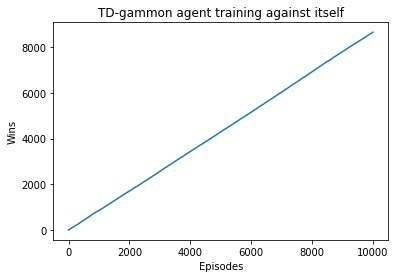

In [ ]:
# model class for td gammon agent to learn best moves
# Original code derived and modified from github repository https://github.com/dunstall/td-gammon, by creator Andrew Dunstall


import copy
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

class Model:
    
    # here we set up the neural network parameters for learning to take place
    Lambda = 0.7
    Alpha = 0.1

    def __init__(self):
        
        # initialize model, and use random weights
        # restore_path is the path to some checkpoint to restore, if given, else it is set to None
        inputs = tf.keras.Input(shape=(198,))  # input layer with 198 nodes for encoded data of board
        
        x = tf.keras.layers.Dense(40, activation="sigmoid")(inputs)  # hidden layer with 40 nodes, using sigmoid function
        outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)  # output layer with 1 node, indicates probability of winning, from given board state
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)

        self.trace = []
        game = Game(   # agent learns from playing itself
            TDGammonAgent(self, 0),
            TDGammonAgent(self, 1)
           
        )   # set up for neural network
        self.state = tf.Variable(game.board.encode_state(0))   # feed state to nn
        self.value = tf.Variable(self.model(self.state[np.newaxis]))

    def train(self, n_episodes):
        # train the model
        print("Training model....")
        wins=0
        wins_ = []
        episode_ = []
        for episode in range(1, n_episodes + 1):
            # run episode
            episode_.append(episode)
            print("Episode", episode)
            
            player = 0
            game = Game(  # set up game
                TDGammonAgent(self, player),
                TDGammonAgent(self, 1 - player)
            )
            game.play()  # run game

            if game.won(player):
                wins += 1   
            print("Wins:", wins)
            wins_.append(wins)
            self.reset_trace()   # reset traces

        
        print("Training complete")

        print("Running agent against random agent.....")
        test_ = []
        test = 1
        wins = 0
        while test<11:
          print("Test:", test)
          for episode in range(101):      
                print("Episode", episode)
                          
                game = Game(         
                    TDGammonAgent(self, player), RandomAgent(1-player)
                )
                game.play()  # run game

                if game.won(player):
                    wins += 1   

                      
                print("Wins:", wins)
          test_.append(wins)
          wins=0
          test+=1
        print("Wins:",test_)
        print("Percentage agent has beaten RandomAgent:", wins/100)
        plt.title("TD-gammon agent training against itself")
        plt.ylabel("Wins")
        plt.xlabel("Episodes")
        x_points = np.array(episode_)
        y_points = np.array(wins_)
        plt.plot(x_points, y_points)  
        plt.show() 

    def action(self, board, roll, player):
        # selects best action from state of environment, in this case the board

        max_move = None   
        max_prob = -np.inf
        permitted = board.Permitted_Moves(roll, player)   # get list of legal moves
        for move in permitted:
            afterstate = copy.deepcopy(board)       # take action, observe next state 
            if not afterstate.move(*move, player):
                # agent has made an invalid move
                continue

            state = afterstate.encode_state(player)[np.newaxis]   # update current state with new state
            prob = tf.reduce_sum(self.model(state))

            if prob > max_prob:  # update max probability, so later on can do action that maximize probability of agent winning
                max_prob = prob
                max_move = move

        if self.state is None:
            self.state = tf.Variable(board.encode_state(player))   # used for nn to update weights and to improve decision making
        if self.value is None:
            self.value = tf.Variable(self.model(self.state[np.newaxis]))

        return max_move     

    def update(self, board, player):
        # update the network, by calculating the gradient

        x_next = board.encode_state(player)   # current state of board
        with tf.GradientTape() as tape:    # starting process of computing the gradient
            value_next = self.model(x_next[np.newaxis])

        trainable_vars = self.model.trainable_variables
        grads = tape.gradient(value_next, trainable_vars)

        # initialize when gradient shape known.
        if len(self.trace) == 0:
            for grad in grads:
                self.trace.append(tf.Variable(
                    tf.zeros(grad.get_shape()), trainable=False
                ))

        if board.won(player):   # only give reward of 1 when agent has won the game
            reward = 1
        else:
            reward = 0

        td_error = tf.reduce_sum(reward + value_next - self.value)   # td_error function, want to reduce this error
        for i in range(len(grads)):
            self.trace[i].assign((self.Lambda * self.trace[i]) + grads[i])  # update eligability trace

            grad_trace = self.Alpha * td_error * self.trace[i]  
            self.model.trainable_variables[i].assign_add(grad_trace) # basically updating the weights of the network

        self.state = tf.Variable(x_next)
        self.value = tf.Variable(value_next)

    def reset_trace(self):    
        print("Resetting trace......") 
        for i in range(len(self.trace)):
            self.trace[i].assign(tf.zeros(self.trace[i].get_shape()))

if __name__=="__main__":
    m = Model()
    m.train(10000)
